In [3]:
#export 
source("exp/nb_02.R")

In [4]:
dfs = readRDS(paste(data_path,"dfs_filtered.rds"))
names(dfs)

[1] "METABRIC" "GSE11121" "GSE96058" "GSE7390"  "GSE9893"  "NKI"      "TCGA"    
[8] "GSE4922"

### Huang, S., Murphy, L. & Xu, W. Genes and functions from breast cancer signatures. BMC Cancer 18, 473 (2018). 

DOI
https://doi.org/10.1186/s12885-018-4388-4

#### Background
Breast cancer is a heterogeneous disease and personalized medicine is the hope for the improvement of the clinical outcome. Multi-gene signatures for breast cancer stratification have been extensively studied in the past decades and more than 30 different signatures have been reported. A major concern is the minimal overlap of genes among the reported signatures. We investigated the breast cancer signature genes to address our hypothesis that the genes of different signature may share common functions, as well as to use these previously reported signature genes to build better prognostic models.

#### Methods
A total of 33 signatures and the corresponding gene lists were investigated. We first examined the gene frequency and the gene overlap in these signatures. Then the gene functions of each signature gene list were analysed and compared by the KEGG pathways and gene ontology (GO) terms. A classifier built using the common genes was tested using the METABRIC (Molecular Taxonomy of Breast Cancer International Consortium) data. The common genes were also tested for building the Yin Yang gene mean expression ratio (YMR) signature using public datasets (GSE1456 and GSE2034).

- The 70-gene signature [1] and the 21-gene signature [4] can distinguish patients with different risk for relapse and patients with high risk benefit more from adjuvant chemotherapy (CT) than patients with low risk. 
- The 97-gene genomic grade index [15] divides classic histologic grade into low and high risk patients. 
- The breast cancer index [21] divides patients into groups with different risk of recurrences, and low-risk patients have high responsiveness to adjuvant tamoxifen therapy. 
- The EndoPredict [33] predicts the high-risk or low-risk groups of relapse, indicating CT/no CT. 
- The PAM50 assay [3] is a classifier for subtyping breast cancer into five subtypes: luminal A (LumA), luminal B (LumB), HER2-enriched (Her2), basal-like (Basal) and normal-like (Normal). PAM50 assay [3] also assesses a patient’s risk of distant recurrence of disease and likelihood of efficacy from neoadjuvant CT.

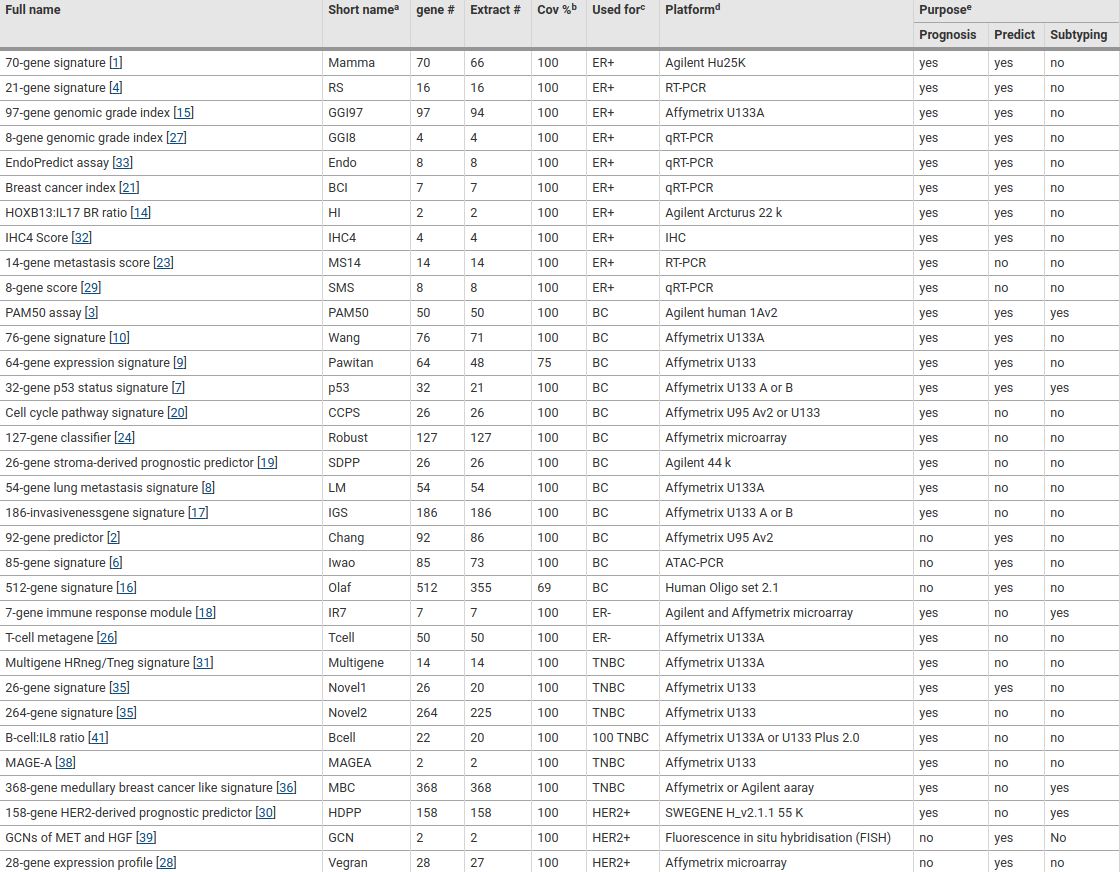

In [5]:
display_png(file="../images/signatures_table.png") 

*a The short name for the full name used in this paper

*b For some signatures with 100% coverage (all signature genes were found in data set), the extracted gene No (Extract# column) is less than the reported gene No (gene# column) because some genes are duplicated with different probe names within a signature

*c The subtype the signatures are developed for: ER+, the signature is used for ER-positive breast cancer; ER-, the signature is used for ER-negative breast cancer; uc-BC, the signature is used for un-classified breast cancer with mixed subtypes; TNBC, the signature is used for TNBC or basal breast cancer; HER2+, the signature is used for HER2-positive breast cancer

*d The experimental platform used for developing the signatures

*e The clinical purpose of these signatures: prognosis, the signature can be used for prognosis; prediction, the signature can be used for predicting the response to treatment or drug; subtyping, the signature can be used for further subtyping breast cancers

#### Signature genes 
We searched PubMed for breast cancer gene signatures or classifiers (Table 1, Additional file 1: Table S1), and collected the gene lists from the original publications. We used HUGO gene symbols to build the gene lists. If only probe IDs were available the gene symbols for the probe IDs were retrieved from the corresponding annotations for the platforms. Since some studies used different gene alias names, we uniformly identified all gene names as official gene symbols by a custom R script. Signatures without gene symbols or probe IDs available were excluded.

### Get gene names for 30 signatures

Additional file 2:
Table S2. 
Gene distribution among the signatures. A matrix with each of all signature genes against each of the 33 signatures to see how the genes distribute among those signatures.

In [6]:
G = read_csv(paste(data_path, "12885_2018_4388_MOESM2_ESM.csv", sep = "/"), col_names = T)


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  X1 = col_double()
)
ℹ Use `spec()` for the full column specifications.




In [7]:
dim(G)

[1] 1895   35

In [8]:
colnames(G)

[1] "X1"        "gene"      "Bcell"     "BCI"       "CCPS"      "Chang"    
 [7] "Endo"      "GCN"       "GGI8"      "GGI97"     "HDPP"      "HI"       
[13] "IGS"       "IHC4"      "IR7"       "Iwao"      "LM"        "MAGEA"    
[19] "Mamma"     "MBC"       "MS14"      "Multigene" "Novel1"    "Novel2"   
[25] "Olaf"      "p53"       "PAM50"     "Pawitan"   "Robust"    "RS"       
[31] "SDPP"      "SMS"       "Tcell"     "Vegran"    "Wang"

In [9]:
signatures = vector("list", 33)
for (i in 1:33){
        signatures[[i]] = correct_gene_names(G$gene[G[,(i+2)]=="yes"])
}
names(signatures) = names(G)[3:35]

### Correct initial signature gene names

In [178]:
signatures$RS[signatures$RS=="Survivin"] = "BIRC5"

### Get signature gene names, find aliases if missing

In [18]:
#export
# load the annotation database
library(org.Hs.eg.db)
library(DBI)
library(testit)

In [212]:
#export
find_all_aliases_4_one_gene = function(gene){
    dbCon <- org.Hs.eg_dbconn()
    sqlQuery <- 'SELECT * FROM alias, gene_info WHERE alias._id == gene_info._id;'
    M = dbGetQuery(dbCon, sqlQuery)
    aliases = M$alias_symbol[M$symbol==gene]
    symbol = M$symbol[M$alias_symbol==gene]
    as.list(c(gene,symbol, aliases))
    }

In [215]:
#export
coexpressed = function(gene){gene %in% colnames(df_corr)} 

In [216]:
#export
find_coexpressed_gene = function(gene, genes_present, df){
    coexpressed_genes = df_corr[,gene]
    for(i in 1:length(coexpressed_genes)){
       coexpressed_gene = coexpressed_genes[[i]]
       if((correct_gene_names(coexpressed_gene) %in% colnames(df)) & !(coexpressed_gene %in% genes_present) ){
           break
       }
       else(coexpressed_gene = "None")
    }
    coexpressed_gene
}

In [217]:
#export
get_one_alias_4_one_gene = function(aliases, genes_present, df){
    assert(class(aliases)=="list")
    for(i in length(aliases)){
        alias = aliases[[i]]
        if(correct_gene_names(alias) %in% colnames(df)){break}
        else if(coexpressed(alias)){
            alias = find_coexpressed_gene(alias, genes_present, df)
        }
        else{alias = "None"}
    }
    return(alias)
}

In [218]:
#export
find_signature_in_df = function(genes, df){    
    genes_present = genes[correct_gene_names(genes) %in% colnames(df)]
    genes_missing = genes[!(correct_gene_names(genes) %in% colnames(df))]
    
    get_aliases = partial(get_one_alias_4_one_gene, genes_present = genes_present, df = df)
    find_aliases = compose(get_aliases, find_all_aliases_4_one_gene)
    
    genes_found = map(genes_missing, find_aliases)
    genes_found = genes_found[genes_found!="None"]
    unique(c(genes_present, genes_found))
}

In [219]:
dfs_signatures = vector("list", length(dfs))
for (i in 1:length(dfs)){
    df = dfs[[i]]
    find_signature = partial(find_signature_in_df, df = df)
    signatures_in_df = map(signatures, find_signature)
    signatures_in_df = map(signatures_in_df, correct_gene_names)
    cols4df = map(signatures_in_df, function(x) c("survival_time", "event",x))
    dfs_signatures[[i]] = map(1:length(cols4df), function(i) df[,unlist(cols4df[[i]])])
    print(length(dfs_signatures[[i]]))
    }

[1] 33
[1] 33
[1] 33
[1] 33
[1] 33
[1] 33
[1] 33
[1] 33


## Get top 10 coexpressed genes from the Coexpression database (https://coxpresdb.jp/download/)

In [98]:
library("data.table")

In [106]:
#dname = "../data/coexpression/Hsa-r.v18-12.G22897-S22897.combat_pca_subagging.mrgeo.d/"
dname = "../data/coexpression/Hsa-u.v18-12.G26050-S164823.combat_pca_subagging.mrgeo.d/"

In [107]:
fnames = list.files(dname)

In [108]:
length(fnames)

[1] 26050

In [109]:
"5480" %in% fnames

[1] TRUE

In [110]:
n_top_corrs = 10

In [111]:
get_top_correlations = function(fname){
    f = fread(paste(dname, fname, sep = ""))
    as.character(f$V1[2:(n_top_corrs+1)])
}

In [112]:
coexpressed_genes = map(fnames, get_top_correlations)

In [114]:
#export
library(org.Hs.eg.db)
library(annotate)

In [115]:
#export
entrez_2_symbol = function(entrez_numbers){
    unname(getSYMBOL(entrez_numbers, data='org.Hs.eg'))
}

In [116]:
entrez_2_symbol(coexpressed_genes[[1]])

[1] "A1BG-AS1" "ALKBH7"   "ZNF497"   "RABAC1"   "FUOM"     "EVA1B"   
 [7] "TMEM256"  "CLEC11A"  "MGMT"     "VKORC1"

In [117]:
n_col = length(coexpressed_genes)

In [118]:
df_corr = data.frame(matrix(ncol = n_col, nrow = n_top_corrs))

In [119]:
for(i in 1:n_col){
    df_corr[,i] = entrez_2_symbol(coexpressed_genes[[i]])
}

In [120]:
names(df_corr) = entrez_2_symbol(fnames)

In [121]:
df_corr[,1:10]

A1BG,NAT2,ADA,CDH2,AKT3,POU5F1P5,ZBTB11-AS1,MED6,NR2E3,NAALAD2
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A1BG-AS1,MOGAT2,LINC01260,GPC6,TRPC1,SNORA70G,UFSP1,NGDN,CT62,HFM1
ALKBH7,C3orf85,SEPTIN6,CDH6,KLF12,LOC105372770,DNAJC30,SNW1,THSD4,PABPC5
ZNF497,IYD,TTYH2,MMP16,ZBTB18,LOC105373674,LINC01465,FCF1,LINC00895,KCNT2
RABAC1,OTC,RHOH,PCDH10,RECK,LARS2-AS1,JMJD4,ALKBH1,TSSK1B,PREX2
FUOM,SLC17A4,DDB2,FN1,HDGFL3,LOC100505736,TMEM202-AS1,PPP4R3A,TULP1,ADGRB3
EVA1B,CYP2C9,ITGA5,ADAM19,SYT11,LOC105374310,USP46-DT,ZNF410,DYDC1,NA
TMEM256,ADGRG7,RPS19,CADM1,TMOD2,LOC107987182,LOC101927330,GPATCH2L,PDX1,EGFEM1P
CLEC11A,FABP1,TMEM161A,COL4A1,SGCB,ASAP1-IT1,FOXN3-AS1,VCPKMT,TOP1P2,LRCH2
MGMT,CLRN3,CHST12,FBN2,LIX1L,PRKCA-AS1,NOP14-AS1,EAPP,ADAM3A,SCN7A


In [123]:
df_corr[,"ESR1"]

[1] "LOC107986529" "PGR"          "CCDC170"      "LOC107986528" "GREB1"       
 [6] "IL20"         "AR"           "LINC01016"    "SERPINA5"     "SPDEF"

In [124]:
saveRDS(df_corr, paste(data_path,"df_coexpression.rds"))

In [125]:
df_corr = readRDS(paste(data_path,"df_coexpression.rds"))

## Tmp begin

### Gene Ontology semantic similarity measurement

In [185]:
library(GOSemSim)

In [7]:
hsGO = godata('org.Hs.eg.db', ont="MF", computeIC=FALSE)

preparing gene to GO mapping data...



In [9]:
goSim("GO:0004022", "GO:0005515", semData=hsGO, measure="Wang")

[1] 0.116

In [10]:
hsGO = godata('org.Hs.eg.db', keytype = "SYMBOL", ont="MF", computeIC=FALSE) 

preparing gene to GO mapping data...



In [11]:
df = dfs[[1]]

In [13]:
genes_df = names(df)[100:1000]

In [14]:
length(genes_df) 

[1] 901

In [15]:
gene_of_interest = c("ESR1")

In [16]:
gene_of_interest

[1] "ESR1"

In [17]:
genes = c(gene_of_interest, genes_df)

In [18]:
genes[1:20]

[1] "ESR1"    "SELENOM" "CTRB2"   "DCK"     "FOXI1"   "ZFPM1"   "RNF224" 
 [8] "UTY"     "GPR32"   "KDM2B"   "ZCCHC9"  "COX11"   "CYP26A1" "WNT2B"  
[15] "H2BC5"   "GADD45G" "ABCD4"   "FAM193A" "TGS1"    "PYROXD1"

In [19]:
M = mgeneSim(genes, semData=hsGO, measure="Wang", combine="BMA", verbose=FALSE)

In [20]:
G = M[gene_of_interest,]

In [21]:
G[1:10]

ESR1 SELENOM   CTRB2     DCK   FOXI1   ZFPM1     UTY   GPR32   KDM2B  ZCCHC9 
  1.000   0.463   0.087   0.320   0.553   0.731   0.461   0.131   0.492   0.464

In [22]:
get_max = function(x){
    x = x[x!=1]
    which.max(x)
}

In [23]:
get_max(M[gene_of_interest,])

NFAT5 
  411

In [24]:
M[411]

[1] 0.456

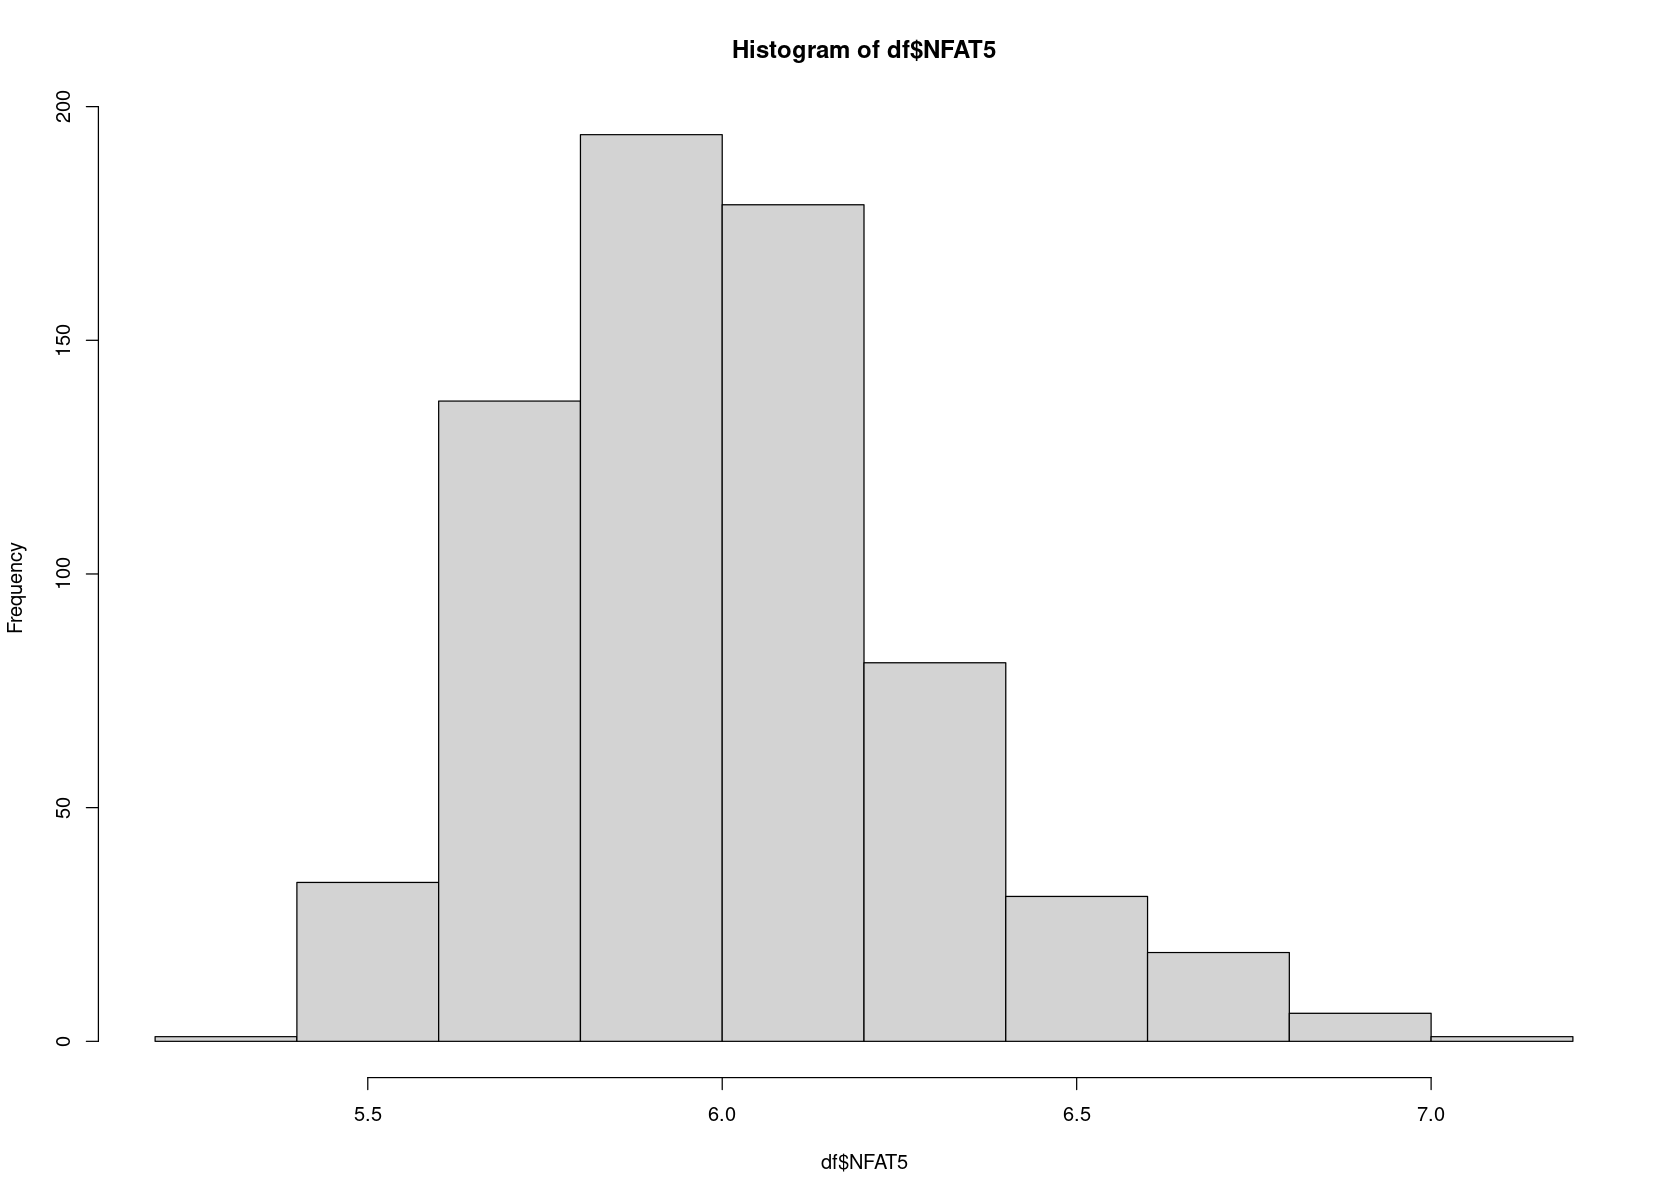

In [25]:
hist(df$NFAT5)

## Tmp end

## Save data

In [240]:
saveRDS(dfs_signatures, paste(data_path,"dfs_signatures.rds"))

## Export code

In [241]:
system("python3 notebook2script.py 03a_select_known_signatures.ipynb")

# Summary

In [220]:
tt = read_csv("../additional_material/table_signatures_from_paper.csv", col_names = F)
colnames(tt) = c("Full_name", "Short_name", "gene_number", "Extract_number", "Cov", "Used_for", "Platform",
                 "Prognosis", "Predict", "Subtyping")


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_character(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_character()
)




In [222]:
n_col = length(dfs_signatures)
stats = data.frame(matrix(ncol = (n_col+2), nrow = 33))

In [223]:
stats[,1] = tt$Full_name[order(match(tt$Short_name,names(signatures)))]
stats[,2] = tt$gene_number[order(match(tt$Short_name,names(signatures)))]
for (col in 1:n_col){stats[,(2+col)] = unlist(map(dfs_signatures[[col]], function(x) (dim(x)[2]-2)))}

In [224]:
colnames(stats) = c("Signature", "genes #", names(dfs))

In [225]:
stats

Signature,genes #,METABRIC,GSE11121,GSE96058,GSE7390,GSE9893,NKI,TCGA,GSE4922
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B-cell:IL8 ratio [41],22,7,11,9,11,9,5,14,10
Breast cancer index [21],7,7,7,7,7,7,7,7,7
Cell cycle pathway signature [20],26,26,26,26,26,26,26,26,25
92-gene predictor [2],92,80,80,80,80,80,80,80,78
EndoPredict assay [33],8,8,8,8,8,8,8,8,8
GCNs of MET and HGF [39],2,2,2,2,2,2,2,2,2
8-gene genomic grade index [27],4,4,4,4,4,4,4,4,4
97-gene genomic grade index [15],97,87,87,87,87,68,86,87,83
158-gene HER2-derived prognostic predictor [30],158,152,151,152,151,152,152,152,151


### Save table

In [242]:
saveRDS(stats, paste(data_path,"signatures_included_in_analysis.rds"))